# Qwen2-VL

In [1]:
# Inference section must be on 3.10.14 # green_score must be on different, as only works on specific python versio 
import sys
sys.version

'3.10.14 (main, May  6 2024, 19:42:50) [GCC 11.2.0]'

In [2]:
# Python 3.10.14
# Below works only on Python > 3.9 
# pip3 install torch torchvision torchaudio --index-url https://download.pytorch.org/whl/cu121 --upgrade --force-reinstall
# pip show torch # 2.5.1+cu121
# pip install "unsloth[colab-new] @ git+https://github.com/unslothai/unsloth.git"
# pip install pandas matplotlib pillow tqdm 
# pip install gdown

In [3]:
if False: 
    !gdown https://drive.google.com/uc?id=1nlc9-jm9eFIwLyMHdPqmxauB-fHyrkTn

    import shutil
    shutil.unpack_archive('data.zip') 

In [4]:
import json
from pathlib import Path
import pandas as pd
import matplotlib.pyplot as plt
from PIL import Image
from tqdm.notebook import tqdm

#from unsloth import FastVisionModel
#import torch

from collections import Counter
pd.options.display.max_rows = 5

# Data pre-processing

Assumptions:
- Train, test data only for now, no val data used

In [5]:
# Images

path_images = Path("data/images")
ids_images = [folder.name for folder in path_images.iterdir() if folder.is_dir()]

len(ids_images), ids_images[:3]

(2955, ['CXR1000_IM-0003', 'CXR1001_IM-0004', 'CXR1004_IM-0005'])

In [6]:
# Annotations

path_annot = 'data/annotation_quiz_all.json'
with open(path_annot, 'r') as f:
    data = json.load(f)

filtered_data = {k: v for k, v in data.items() if k in ['test', 'train']}

df_train = pd.DataFrame(filtered_data['train'])
df_test  = pd.DataFrame(filtered_data['test'])
df_data  = pd.concat([df_train, df_test], ignore_index=True)

assert len(set(df_data.id)) == len(df_data.id)

df_data = df_data.set_index('id')
df_data

,report,split
id,,
CXR2384_IM-0942,{'bone': 'Degenerative changes are present in ...,train
CXR2926_IM-1328,"{'bone': 'Bony structures are intact.', 'heart...",train
...,...,...
CXR2312_IM-0887,"{'bone': '', 'heart': 'The heart is normal in ...",test
CXR49_IM-2110,{'bone': 'Degenerative changes of the thoracic...,test


In [7]:
ids_annot = df_data.index.to_list()
assert all(item in ids_images for item in ids_annot)

len(ids_annot), ids_annot[:3]

(2659, ['CXR2384_IM-0942', 'CXR2926_IM-1328', 'CXR1451_IM-0291'])

In [8]:
def concatenate_images_vertically(image1, image2, shared_width=512):

    assert shared_width == image1.width == image2.width

    total_height = image1.height + image2.height
    concatenated_image = Image.new('RGB', (shared_width, total_height))
    concatenated_image.paste(image1.crop((0, 0, shared_width, image1.height)), (0, 0))
    concatenated_image.paste(image2.crop((0, 0, shared_width, image2.height)), (0, image1.height))
    return concatenated_image

df_data['image'] = None
for folder_id in tqdm(ids_annot):
    try:
        img0 = Image.open(path_images / folder_id / "0.png")
        img1 = Image.open(path_images / folder_id / "1.png")
        concatenated_image = concatenate_images_vertically(img0, img1)

        df_data.loc[folder_id , 'image'] = concatenated_image

    except FileNotFoundError as e:
        print(f"File not found: {e}")

df_data

  0%|          | 0/2659 [00:00<?, ?it/s]

,report,split,image
id,,,
CXR2384_IM-0942,{'bone': 'Degenerative changes are present in ...,train,<PIL.Image.Image image mode=RGB size=512x1044 ...
CXR2926_IM-1328,"{'bone': 'Bony structures are intact.', 'heart...",train,<PIL.Image.Image image mode=RGB size=512x1074 ...
...,...,...,...
CXR2312_IM-0887,"{'bone': '', 'heart': 'The heart is normal in ...",test,<PIL.Image.Image image mode=RGB size=512x1248 ...
CXR49_IM-2110,{'bone': 'Degenerative changes of the thoracic...,test,<PIL.Image.Image image mode=RGB size=512x1044 ...


In [9]:
# df_data.to_pickle('data/df_data.pkl') # should hande images
df_data.drop(columns='image').to_pickle('data/df_data.pkl')

In [10]:
data_test  = df_data.loc[df_data['split'] == 'test',  :].copy()
data_test

,report,split,image
id,,,
CXR3030_IM-1405,"{'bone': 'No acute bony abnormality.', 'heart'...",test,<PIL.Image.Image image mode=RGB size=512x1044 ...
CXR38_IM-1911,"{'bone': 'Bony structures are intact.', 'heart...",test,<PIL.Image.Image image mode=RGB size=512x1248 ...
...,...,...,...
CXR2312_IM-0887,"{'bone': '', 'heart': 'The heart is normal in ...",test,<PIL.Image.Image image mode=RGB size=512x1248 ...
CXR49_IM-2110,{'bone': 'Degenerative changes of the thoracic...,test,<PIL.Image.Image image mode=RGB size=512x1044 ...


# Inference on Test Data 

In [47]:
from transformers import TextStreamer

model_name = "Aidan777/Qwen2-VL-7B-Instruct-bnb-4bit_finetuned_xray_report"

model, tokenizer = FastVisionModel.from_pretrained(
                                        model_name=model_name, 
                                        load_in_4bit=True)

==((====))==  Unsloth 2025.1.7: Fast Qwen2_Vl vision patching. Transformers: 4.48.2.
   \\   /|    GPU: NVIDIA RTX A6000. Max memory: 47.536 GB. Platform: Linux.
O^O/ \_/ \    Torch: 2.5.1+cu121. CUDA: 8.6. CUDA Toolkit: 12.1. Triton: 3.1.0
\        /    Bfloat16 = TRUE. FA [Xformers = None. FA2 = False]
 "-____-"     Free Apache license: http://github.com/unslothai/unsloth
Unsloth: Fast downloading is enabled - ignore downloading bars which are red colored!


In [48]:
instruction_user = """
You are a specialist Radiologist specializing in the analysis of chest X-ray images by looking at them.
Your goal is to analyze X-ray images and write diagnostic reports based on X-ray images.
You only write reports for five anatomical regions: lung, heart, mediastinal, bone, and others.
Each report may not necessarily include findings for all regions. Some regions might be empty.
You are provided with a chest X-ray image.
Write a radiology report accurately by looking at the image provided.
Each image is the Frontal and Lateral X-ray images concatenated vertically, with no particular order.
Write the report carefully. Consider each anatomical region separately, but you don't have to write a report for each region.
"""

In [ ]:
FastVisionModel.for_inference(model)

outputs = {}
for i in tqdm(range(len(data_test))):

    image = data_test.iloc[i]['image']
    idx   = data_test.index[i]
    assert isinstance(image, Image.Image)  
    
    messages = [{"role": "user",
                 "content": [{"type": "image"},
                             {"type": "text", "text": instruction_user}]}]

    input_text    = tokenizer.apply_chat_template(messages, add_generation_prompt=True)
    inputs        = tokenizer(image, input_text, add_special_tokens=False, return_tensors="pt").to("cuda")
    text_streamer = TextStreamer(tokenizer, skip_prompt=True)
    
    output = model.generate(**inputs,
                            streamer=text_streamer,
                            max_new_tokens=128, # of the output
                            use_cache=True,
                            temperature=1.5,
                            min_p=0.1)

    decoded_text  = tokenizer.decode(output[0], skip_special_tokens=True)
    required_text = decoded_text.split('assistant\n', 1)[-1]
    del output
    
    outputs[idx] = required_text

In [55]:
file_name = "Qwen2-VL-7B-Instruct-bnb-4bit_finetuned_xray_report_TEST_OUTPUT.json"

with open(file_name, "w") as file:
    json.dump(outputs, file, indent=4) 

- For inference this models takes -
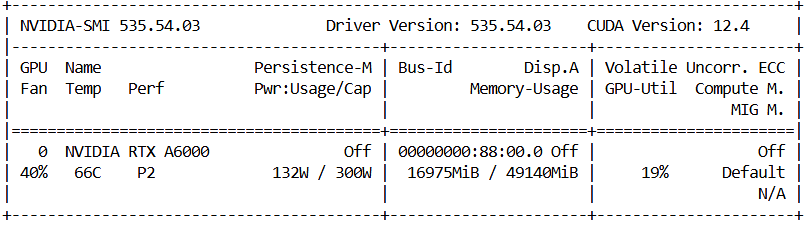

In [54]:
# Notice how many outputs looks the same - not a good sign?

for i, (key, value) in enumerate(outputs.items()):
    if i < 10: print(f"Key: {key}, Value: {value}")
    else: break

Key: CXR3030_IM-1405, Value: bone: No acute bony abnormality. heart: Heart size is normal. lung: Lungs are clear. No pneumothorax or pleural effusion. mediastinal: Mediastinal contour is normal.
Key: CXR38_IM-1911, Value: bone: No acute bony abnormality. heart: Heart size is normal. lung: Lungs are clear. No pneumothorax or pleural effusion. mediastinal: Mediastinal contour is normal.
Key: CXR3957_IM-2022, Value: bone: No acute bony abnormality. heart: Heart size is normal. lung: Lungs are clear. No pneumothorax or pleural effusion. mediastinal: Mediastinal contour is normal.
Key: CXR621_IM-2203, Value: bone: No acute bony abnormality. heart: Heart size is normal. lung: Lungs are clear. No pneumothorax or pleural effusion. mediastinal: Mediastinal contour is normal.
Key: CXR1347_IM-0225, Value: bone: No acute bony abnormalities. heart: Heart size is normal. lung: Lungs are clear. No pneumothorax or pleural effusion. mediastinal: Mediastinal contours are normal.
Key: CXR2915_IM-1317, Va

# Model Performance Evaluation

GREEN: Generative Radiology Report Evaluation and Error Notation. https://github.com/Stanford-AIMI/GREEN/tree/main

To install in Jupyter Labs, first, in terminal:
- make sure you have python >= 3.121 or install it
- python3.12 -m venv myenv3124     # create venv 
- source myenv3124/bin/activate    
- pip install ipykernel
- python3.12 -m ipykernel install --user --name=myenv3124 --display-name "myenv3124"
	

To install GREEN, first: 
- Python 3.12.1 (works on 3.12.4)
- pip install torch==2.2.2 torchvision==0.17.2 torchaudio==2.2.2 --index-url https://download.pytorch.org/whl/cu118

Then follow - https://github.com/Stanford-AIMI/GREEN/tree/main : 
- git clone https://github.com/Stanford-AIMI/GREEN.git
- cd GREEN
- pip install -e .

##  Test green_score

In [1]:
# You must have 3.12.1 or 3.12.4, or similar that works
import json
import sys
print(sys.executable)
from green_score import GREEN

/home/myenv3124/bin/python3.12


In [2]:
model_name = "StanfordAIMI/GREEN-RadLlama2-7b"
green_scorer = GREEN(model_name, output_dir=".")

/home/myenv3124/lib/python3.12/site-packages/huggingface_hub/file_download.py:795: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(


Loading checkpoint shards:   0%|          | 0/3 [00:00<?, ?it/s]

## Calculate green_score on true vs. inferred data

In [5]:
# Load Ground Truth reports

df_data = pd.read_pickle('data/df_data.pkl')

# Select test only and format to strings 
data_test  = df_data.loc[df_data['split'] == 'test',  :].copy()
data_test['report'] = data_test['report'].apply(lambda x: ' '.join([f"{k}: {v}" for k, v in x.items()]))
data_test

,report,split
id,,
CXR3030_IM-1405,bone: No acute bony abnormality. heart: Normal...,test
CXR38_IM-1911,bone: Bony structures are intact. heart: The h...,test
...,...,...
CXR2312_IM-0887,bone: heart: The heart is normal in size. lun...,test
CXR49_IM-2110,bone: Degenerative changes of the thoracic spi...,test


In [6]:
file_name = "Qwen2-VL-7B-Instruct-bnb-4bit_finetuned_xray_report_TEST_OUTPUT.json"

with open(file_name, "r") as file:
    outputs = json.load(file)    

df = pd.DataFrame.from_dict(outputs, orient='index', columns=['report_pred'])
data_test = pd.merge(data_test, df, left_index=True, right_index=True)

In [7]:
data_test

,report,split,report_pred
CXR3030_IM-1405,bone: No acute bony abnormality. heart: Normal...,test,bone: No acute bony abnormality. heart: Heart ...
CXR38_IM-1911,bone: Bony structures are intact. heart: The h...,test,bone: No acute bony abnormality. heart: Heart ...
...,...,...,...
CXR2312_IM-0887,bone: heart: The heart is normal in size. lun...,test,bone: No acute bony abnormality. heart: Heart ...
CXR49_IM-2110,bone: Degenerative changes of the thoracic spi...,test,bone: No acute bony abnormality. heart: Heart ...


In [ ]:
green_scores = pd.DataFrame(index=data_test.index, columns=['mean', 'std'])

for idx, row in data_test.iterrows():
    try:
        mean, std, green_score_list, summary, result_df = green_scorer([row['report']], [row['report_pred']])
                
        green_scores.loc[idx, 'mean'] = mean
        green_scores.loc[idx, 'std'] = std
    except Exception as e:
        print(f"An error occurred at index {idx}: {e}")
        
        green_scores.loc[idx, 'mean'] = None
        green_scores.loc[idx, 'std'] = None

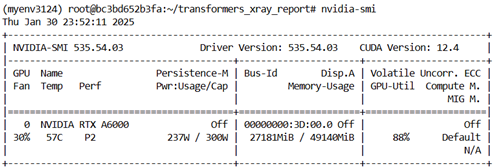

In [9]:
green_scores.to_csv('data/green_scores_Qwen2-VL-7B.csv', index=True)

In [10]:
green_scores

,mean,std
CXR3030_IM-1405,1.0,0.0
CXR38_IM-1911,1.0,0.0
...,...,...
CXR2312_IM-0887,1.0,0.0
CXR49_IM-2110,0.375,0.0


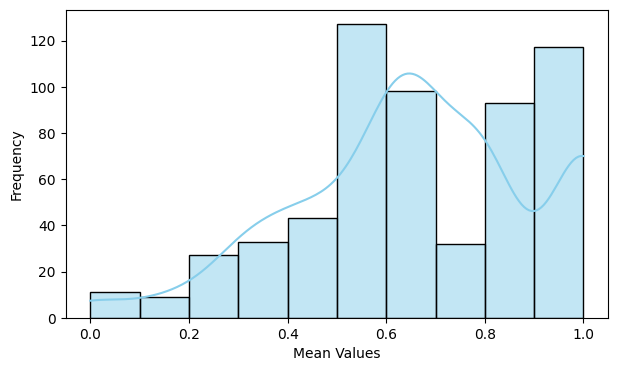

In [11]:
# Kernel Density Estimate plot

import seaborn as sns
plt.figure(figsize=(7, 4))
sns.histplot(green_scores['mean'], bins=10, kde=True, color='skyblue')
plt.xlabel('Mean Values'); plt.ylabel('Frequency');